# 1 Data Importation and Cleaning

## 1.1 Loading the data
The **data** folder from the **Brain Tumour Dataset** folder has been zipped and uploaded to Google Drive. The code starts by extracting the zip folder and loading it into the working space.

In [1]:
import gdown

id = "1_fFw05mfmJlGSmJLORsXLV94tVfCxl37" # id of the zipped Data folder
gdown.download(id="1_fFw05mfmJlGSmJLORsXLV94tVfCxl37")


Downloading...
From: https://drive.google.com/uc?id=1_fFw05mfmJlGSmJLORsXLV94tVfCxl37
To: /content/brain_tumour_images.zip
100%|██████████| 6.80M/6.80M [00:00<00:00, 111MB/s]


'brain_tumour_images.zip'

## 1.2 Processing the data
### 1.2.1 Primary processing (original) of the data
As the raw dataset was given in JPG format, data processing was required in order to get X values and Y values in numpy arrays.


In [2]:
import os
import zipfile
import numpy as np
from PIL import Image

def get_X():
  wd = os.getcwd()
  with zipfile.ZipFile(f"{wd}/brain_tumour_images.zip", 'r') as zip_ref:
    zip_ref.extractall(wd)
  base_path = f"{wd}/data"
  # get source folder paths of benign and malignant images
  benign_path = base_path + "/benign/"
  malignant_path = base_path + "/malignant/"
  benign = os.listdir(benign_path)
  malignant = os.listdir(malignant_path)

  all_benign = np.empty((0,244*244), dtype=float, order='C')
  for file in benign:
      img_path = benign_path + file
      img = Image.open(img_path).resize((244,244)).convert('L')
      numpydata = np.asarray(img).reshape((1,244*244))
      all_benign = np.append(all_benign, numpydata, axis = 0)
  # print(f"benign shape = {all_benign.shape}")

  all_malignant = np.empty((0,244*244), dtype=float, order='C')
  for file in malignant:
      if ".DS_Store" in file:
          continue
      img_path = malignant_path + file
      img = Image.open(img_path).resize((244,244)).convert('L')
      numpydata = np.asarray(img).reshape((1,244*244))
      all_malignant = np.append(all_malignant, numpydata, axis = 0)
  # print(f"malignant shape = {all_malignant.shape}")

  X_raw_original = np.concatenate((all_benign,all_malignant))  
  # print(f"X shape (ori)= {X_raw_original.shape}")

  return X_raw_original

X_raw_original = get_X()
print(f"X shape (ori) = {X_raw_original.shape}")
  
def create_y(n_benign,n_malignant):
  Y = np.zeros(n_benign+n_malignant)
  Y[n_benign:] = 1
  return Y
Y_original = create_y(77,154)
print(f"Y shape (ori) = {Y_original.shape}")

X shape (ori) = (231, 59536)
Y shape (ori) = (231,)


### 1.2.1 Improved processing of the data
As an attempt to refine the dataset in 1.2.1, we did some outlining, contouring and cropping of images.

In [3]:
#for improved preprocessing
import os
from PIL import Image
import numpy as np
import zipfile
import cv2
from google.colab.patches import cv2_imshow
import imutils
import matplotlib.pyplot as plt

wd = os.getcwd()
with zipfile.ZipFile(f"{wd}/brain_tumour_images.zip", 'r') as zip_ref:
   zip_ref.extractall(wd)
base_path = f"{wd}/data"
benign_path = base_path + "/benign/"
malignant_path = base_path + "/malignant/"
benign = os.listdir(benign_path)
malignant = os.listdir(malignant_path)

all_benign_improved = np.empty((0,244*244), dtype=float, order='C')

def threshed(image):
  thresh = cv2.threshold(image, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)
  thresh = thresh.astype(np.uint8)   
  return thresh

def contours(image):
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,	cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)
  return c

def extreme_points(c):
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  return extLeft, extRight, extTop, extBot

#def draw(image, extLeft, extRight, extTop, extBot):
  # cv2.drawContours(image, [c], -1, (0, 255, 255), 2)
  # cv2.circle(image, extLeft, 8, (0, 0, 255), -1)
  # cv2.circle(image, extRight, 8, (0, 255, 0), -1)
  # cv2.circle(image, extTop, 8, (255, 0, 0), -1)
  # cv2.circle(image, extBot, 8, (255, 255, 0), -1)
  

for file in benign:
  # retrieving image from file directory
  img_path = benign_path + file
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) #note: this converts img class to array
  #cv2_imshow(img)
  
  #check if img is RGB or grayscale
  if(len(img.shape) != 3):
    gray = cv2.GaussianBlur(img, (5, 5), 0)
  else:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = gray
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

  # threshold the image, then perform a series of erosions and dilations to remove any small regions of noise
  # Besides ensuring that image is greyscaled, image must also be of type uint8
  # Thresh before conversion was of type float32 (CHECK)
  thresh = threshed(gray)  
  #cv2_imshow(thresh) 
  
  # find contours in thresholded image, then grab the largest one
  c = contours(thresh)

  # determine the most extreme points along the contour
  extLeft, extRight, extTop, extBot = extreme_points(c)

  # draw the outline of the object, then draw each of the extreme points
  # draw(img, extLeft, extRight, extTop, extBot)

  # crop out the brain
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  # resizing image to (244, 244)
  new_img = cv2.resize(new_img, dsize=(244,244), interpolation=cv2.INTER_CUBIC)
  #cv2_imshow(new_img)

  #append to all_benign
  all_benign_improved = np.append(all_benign_improved, new_img.reshape((1,244*244)), axis=0)

print(f"benign shape (improved) = {all_benign_improved.shape}")

all_malignant_improved = np.empty((0,244*244), dtype=float, order='C')
for file in malignant:
  if ".DS_Store" in file:
    continue

  # retrieving image from file directory
  img_path = malignant_path + file
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
  #cv2_imshow(img)   
  
  # load the image, convert it to grayscale, and blur it slightly
  if len(img.shape) == 3:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img=gray
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    #print(f"was rgb {img.shape}")

  else:
    gray = cv2.GaussianBlur(img, (5, 5), 0)
    #print(f"was gray {img.shape}")

  # threshold the image, then perform a series of erosions and dilations to remove any small regions of noise
  # Besides ensuring that image is greyscaled, image must also be of type uint8
  # Thresh before conversion was of type float32 (CHECK)
  thresh = threshed(gray)  
  #cv2_imshow(thresh) 
  
  # find contours in thresholded image, then grab the largest one
  c = contours(thresh)

  # determine the most extreme points along the contour
  extLeft, extRight, extTop, extBot = extreme_points(c)

  # draw the outline of the object, then draw each of the extreme points
  # draw(img, extLeft, extRight, extTop, extBot)
 
  # crop out the brain
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
  #cv2_imshow(new_img)
  #print(new_img, "crop" + file)
  #print(f"new {new_img.shape}")

  # resizing image to (244, 244)
  new_img = cv2.resize(new_img, dsize=(244,244), interpolation=cv2.INTER_CUBIC)
  #print(f"new244 {new_img.shape}"
  all_malignant_improved = np.append(all_malignant_improved, new_img.reshape((1,244*244)), axis=0)
  
#print(all_malignant)
print(f"malignant shape (improved) = {all_malignant_improved.shape}")

#combining the improved benign and malignant dataset
X_raw_improved = np.concatenate((all_benign_improved, all_malignant_improved))  
print(f"X shape (imp) = {X_raw_improved.shape}")

def create_y(n_benign,n_malignant):
  Y = np.zeros(n_benign+n_malignant)
  Y[n_benign:] = 1
  return Y

Y_improved = create_y(77,154)
print(f"Y shape (imp) = {Y_improved.shape}")

benign shape (improved) = (77, 59536)
malignant shape (improved) = (154, 59536)
X shape (imp) = (231, 59536)
Y shape (imp) = (231,)


## 1.3 Train-test Split

We split the data into training data and testing data using the sk_learn function. We noted that it is important that this splitting is done randomly as our data has been ordered such that all benign data occur before malignant data.

In [4]:
#do test train split
from sklearn.model_selection import train_test_split

def split_train_test(X,Y):
  xtrain, xtest, ytrain, ytest = train_test_split(
        X, Y, test_size = 0.25, stratify = Y, random_state = 1)
  return(xtrain, xtest, ytrain, ytest)
# packed in a function in case comparisons across diff iterations (diff splits of train and test are needed)


ori_splitted = split_train_test(X_raw_original, Y_original)
ori_xtrain, ori_xtest, ori_ytrain, ori_ytest = ori_splitted
print(f"for original: {ori_xtrain.shape,ori_xtest.shape,ori_ytrain.shape,ori_ytest.shape}")

imp_splitted = split_train_test(X_raw_improved, Y_improved)
imp_xtrain, imp_xtest, imp_ytrain, imp_ytest = imp_splitted
print(f"for improved: {imp_xtrain.shape, imp_xtest.shape, imp_ytrain.shape, imp_ytest.shape}")

for original: ((173, 59536), (58, 59536), (173,), (58,))
for improved: ((173, 59536), (58, 59536), (173,), (58,))


## 1.4 Data Augmentation

We augment the data to obtain a larger training dataset using data from the current training dataset. This is necessary to ensure we are not underfitting the models.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

def data_aug(X,Y,rat):
  n_malignant = np.sum(Y)
  n_benign = Y.shape[0] - n_malignant
  n_larger = max(n_benign,n_malignant)
  each = n_larger*rat
  malignant_mult = round((each-n_malignant) / n_malignant)
  benign_mult = round((each-n_benign) / n_benign)
  # print(malignant_mult,benign_mult)
  # multiply benign by ratio to get more benign
  data_augmentation = keras.Sequential([
      keras.layers.RandomFlip("horizontal_and_vertical"),
      keras.layers.RandomRotation(0.2),
  ])
  aug_X = np.empty((0,244,244), dtype=float, order='C')
  aug_Y = np.empty((0), dtype=float, order='C')
  for img in range(0,Y.shape[0]):
    image = np.reshape(X[img,:],(1,244,244,1))
    image = tf.convert_to_tensor(image)
    if Y[img] == 0:
      #benign
      for i in range(0,benign_mult):
        augmented_image = data_augmentation(image).numpy()
        aug_X = np.append(aug_X, augmented_image.reshape((1,244,244)), axis = 0)
        aug_Y = np.append(aug_Y,0)
    elif Y[img] == 1:
      # malignant
      for i in range(0,malignant_mult):
        augmented_image = data_augmentation(image).numpy()
        aug_X = np.append(aug_X, augmented_image.reshape((1,244,244)), axis = 0)
        aug_Y = np.append(aug_Y,1)
    if img%25==24:
      print(f"{img+1}/{X.shape[0]} augmented...")
  print(f"{img+1}/{X.shape[0]} augmented (DONE)")
  def flatten(output):
    # print(output.shape)
    return np.reshape(output,(output.shape[0],244*244))
  aug_X = np.append(flatten(aug_X),X,axis=0)
  aug_Y = np.append(aug_Y,Y)
  return (flatten(aug_X),aug_Y)

print("Augment Original Images")
ori_xtrain_aug, ori_ytrain_aug = data_aug(ori_xtrain,ori_ytrain,2)
print(f"ori_xtrain_aug.shape: {ori_xtrain_aug.shape}")
print(f"ori_ytrain_aug.shape: {ori_ytrain_aug.shape}")
print("---")

print("Augment Improved Images")
imp_xtrain_aug, imp_ytrain_aug = data_aug(imp_xtrain,imp_ytrain,2)
print(f"imp_xtrain_aug.shape: {imp_xtrain_aug.shape}")
print(f"imp_ytrain_aug.shape: {imp_ytrain_aug.shape}")


Augment Original Images
25/173 augmented...
50/173 augmented...
75/173 augmented...
100/173 augmented...
125/173 augmented...
150/173 augmented...
173/173 augmented (DONE)
ori_xtrain_aug.shape: (462, 59536)
ori_ytrain_aug.shape: (462,)
---
Augment Improved Images
25/173 augmented...
50/173 augmented...
75/173 augmented...
100/173 augmented...
125/173 augmented...
150/173 augmented...
173/173 augmented (DONE)
imp_xtrain_aug.shape: (462, 59536)
imp_ytrain_aug.shape: (462,)


## 1.5 Normalising X values
We normalised the training and testing x data as a form of feature scaling to improve numerical stability. To ensure that the same distribution is used for normalisation, We will normalise both validation and training dataset using the distribution of the training set.

In [6]:
def normalise_data(X1, X2): #distribution based on X1, normalise on X2  
  min_X1 = np.min(X1,axis=0)
  col_range_X1 = np.max(X1,axis=0) - min_X1
  return (X2 - min_X1) / col_range_X1 

ori_xtrain_aug_nor = normalise_data(ori_xtrain_aug, ori_xtrain_aug)
ori_xtest_nor = normalise_data(ori_xtrain_aug, ori_xtest)

# imp_xtrain_aug_nor = normalise_data(imp_xtrain_aug,imp_xtrain_aug)
# imp_xtest_nor = normalise_data(imp_xtrain_aug, imp_xtest)

print("ori_xtrain_aug_nor.shape:",ori_xtrain_aug_nor.shape)
print("ori_xtest_nor.shape:",ori_xtest_nor.shape)
# print("imp_xtrain_aug_nor.shape:",imp_xtrain_aug_nor.shape)
# print("imp_xtest_nor.shape:",imp_xtest_nor.shape)

ori_xtrain_aug_nor.shape: (462, 59536)
ori_xtest_nor.shape: (58, 59536)


##1.6 Variable Assignment

For consistent syntax, we assigned processed data to `Xtrain`, `Xtest`, `Ytrain` and `Ytest` for easier reference.

In [7]:
Xtrain = ori_xtrain_aug_nor
Xtest = ori_xtest_nor
Ytrain = ori_ytrain_aug
Ytest = ori_ytest

Xtrain_imp = imp_xtrain_aug # note: improved dataset runs better without normalisation
Xtest_imp = imp_xtest
Ytrain_imp = imp_ytrain_aug
Ytest_imp = imp_ytest


# 2 Machine Learning Algorithms


## 2.1 kNN
A simple kNN was first run with different k values to compare accuracy. However, as high dimensional data is used, we questioned whether the euclidean distance metric is most optimal and researched on different metrics. We found that the cosine distance metric is often used for higher dimensional data and plotted a graph to compare results when the cosine distance metric is used.

Euclidean
Accuracy | Max = 0.7413793103448276 at k=1 Mean = 0.6620689655172413
Balanced Accuracy | Max = 0.7402159244264508 k=1 Mean = 0.6790823211875846
[[14  5]
 [10 29]]
---
Cosine
Accuracy | Max = 0.8275862068965517 at k=1 Mean = 0.7331034482758618
Balanced Accuracy | Max = 0.7773279352226721 k=1 Mean = 0.6444534412955466
[[12  7]
 [ 3 36]]
---


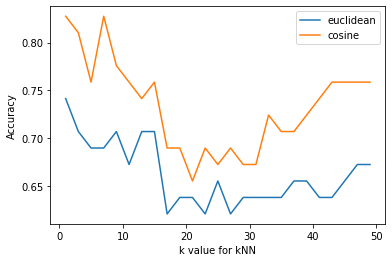

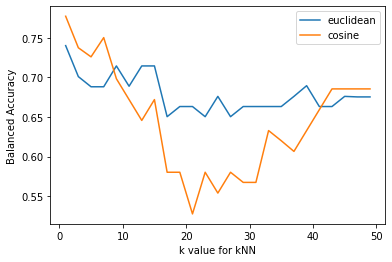

In [8]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,balanced_accuracy_score

# knn classifier from sklearn

def run_kNN(Xtrain,Ytrain,Xtest,Ytest):

  def kNN_brain_tumour(max_k=49,metric="minkowski"):
    accuracy = []
    balanced_accuracy = []
    for n in range(1,max_k+1,2):
      knn = KNeighborsClassifier(n_neighbors=n,metric=metric)
      knn.fit(Xtrain,Ytrain)
      y_knn = knn.predict(Xtest)
      accuracy.append(accuracy_score(Ytest, y_knn))
      balanced_accuracy.append(balanced_accuracy_score(Ytest, y_knn))
    return [accuracy, balanced_accuracy]

  accur_euclidean, balanced_accur_euclidean = kNN_brain_tumour()
  accur_cosine, balanced_accur_cosine = kNN_brain_tumour(metric="cosine")

  def summ_accuracy(dist_metric_str,accur,b_accur):
    print(dist_metric_str)
    print(f"Accuracy | Max = {max(accur)} at k={accur.index(max(accur))*2+1} Mean = {sum(accur)/len(accur)}")
    print(f"Balanced Accuracy | Max = {max(b_accur)} k={b_accur.index(max(b_accur))*2+1} Mean = {sum(b_accur)/len(b_accur)}")
    m = "minkowski"
    if dist_metric_str == "Cosine":
      m = "cosine"
    knn = KNeighborsClassifier(n_neighbors=accur.index(max(accur))*2+1,metric=m)
    knn.fit(Xtrain,Ytrain)
    y_knn = knn.predict(Xtest)
    print(confusion_matrix(Ytest,y_knn))
    print("---")

  summ_accuracy("Euclidean",accur_euclidean,balanced_accur_euclidean)
  summ_accuracy("Cosine",accur_cosine,balanced_accur_cosine)


  def accuracy_plot():
    plt.figure()
    plt.plot(range(1,50,2),accur_euclidean,label="euclidean")
    plt.plot(range(1,50,2),accur_cosine,label="cosine")
    plt.xlabel("k value for kNN")
    plt.ylabel("Accuracy")
    plt.legend()

  def balanced_accuracy_plot(): 
    plt.figure()
    plt.plot(range(1,50,2),balanced_accur_euclidean,label="euclidean")
    plt.plot(range(1,50,2),balanced_accur_cosine,label="cosine")
    plt.xlabel("k value for kNN")
    plt.ylabel("Balanced Accuracy")
    plt.legend()

  accuracy_plot()
  balanced_accuracy_plot()

run_kNN(Xtrain,Ytrain,Xtest,Ytest)


## 2.2 Logistic Regression

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy = 0.741
Balanced Accuracy = 0.74
f1 score = 0.795
Precision = 0.853
Recall = 0.744


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.3s finished


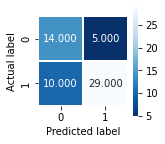

In [9]:
#import modules
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,balanced_accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def LR(xtrain,ytrain,xtest,ytest):
  #fit logistic regression model
  def modelfit():
    classifier = LogisticRegression(max_iter=1000, verbose = 1,  random_state = 123, class_weight = 'balanced')
    classifier.fit(xtrain, ytrain)
    return classifier
  model_ori = modelfit()

  #predict the output of xtest
  def predict(classifier):
    y_pred = classifier.predict(xtest)
    return y_pred
  y_pred_ori = predict(model_ori)

  #evaluate the model:
  def evaluate(y_pred):
    cm = confusion_matrix(ytest, y_pred)
    accuracy = accuracy_score(ytest,  y_pred)
    balancedaccuracy = balanced_accuracy_score(ytest,  y_pred)
    f1score = f1_score(ytest,  y_pred) #F1 is a good scoring metric for imbalanced data when more attention is needed on the positives
    precision = precision_score(ytest, y_pred)
    recall = recall_score(ytest, y_pred)

    print(f"Accuracy = {round(accuracy, ndigits=3)}")
    print(f"Balanced Accuracy = {round(balancedaccuracy, ndigits=3)}")
    print(f"f1 score = {round(f1score, ndigits=3)}")
    print(f"Precision = {round(precision, ndigits=3)}")
    print(f"Recall = {round(recall, ndigits=3)}")
    
    plt.figure(figsize=(2,2))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

  evaluate(y_pred_ori)

LR(Xtrain,Ytrain,Xtest,Ytest)

## 2.3 Neural Network

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 242, 242, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 121, 121, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 32)      18464     
                                                                 
 spatial_dropout2d (SpatialD  (None, 119, 119, 32)     0         
 ropout2D)                                                       
                                                      

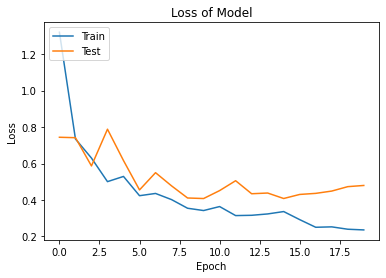

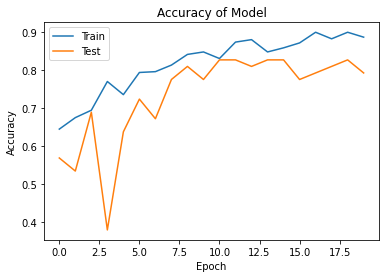

In [10]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization, SpatialDropout2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import tensorflow as tf


def NN(Xtrain,Ytrain,Xtest,Ytest):
  def to_CNN(X):
    return X.reshape(X.shape[0],244,244,1)

  model = Sequential()
  model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu',input_shape=(244,244,1)))
  #We apply Batch Normalization to ensure that the mean and standard deviation of layer inputs remain the same, as computations in the convolution layers and changes in weights during training may cause changes in input distribution
  #Info from https://www.baeldung.com/cs/batch-normalization-cnn
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu'))
  model.add(SpatialDropout2D(0.4))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(units=128,activation='relu'))
  #Apply Dropout, which randomly drops nodes during training in order to reduce overfitting and improve generalisation error
  #Info from https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
  model.add(Dropout(0.5))
  model.add(Dense(units=1,activation='sigmoid'))

  model.summary()
  model.compile(loss='binary_crossentropy',
                optimizer='sgd',
                metrics=['accuracy'])
  history = model.fit(to_CNN(Xtrain),Ytrain,epochs =20 , validation_data = (to_CNN(Xtest), Ytest))

  model.evaluate(to_CNN(Xtest), Ytest)

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss of Model')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy of Model')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

NN(ori_xtrain_aug,ori_ytrain_aug,ori_xtest,ori_ytest)

# 3 ML on Improved Dataset


## 3.1 kNN

Euclidean
Accuracy | Max = 0.6896551724137931 at k=1 Mean = 0.5565517241379311
Balanced Accuracy | Max = 0.7152496626180838 k=1 Mean = 0.626531713900135
[[15  4]
 [14 25]]
---
Cosine
Accuracy | Max = 0.7068965517241379 at k=3 Mean = 0.5889655172413794
Balanced Accuracy | Max = 0.7557354925775979 k=5 Mean = 0.658731443994602
[[17  2]
 [15 24]]
---


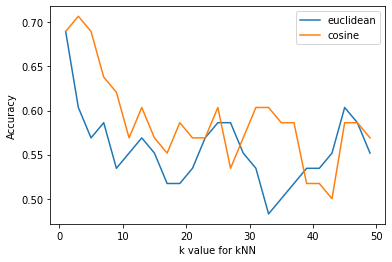

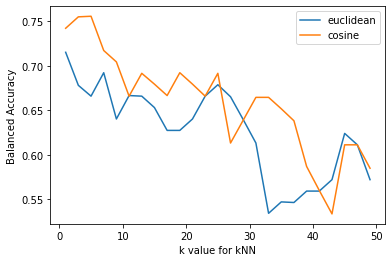

In [11]:
run_kNN(Xtrain_imp,Ytrain_imp,Xtest_imp,Ytest_imp)

## 3.2 Logistic Regression

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy = 0.586
Balanced Accuracy = 0.557
f1 score = 0.676
Precision = 0.714
Recall = 0.641


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s finished


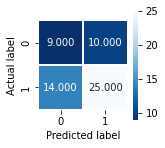

In [12]:
LR(Xtrain_imp,Ytrain_imp,Xtest_imp,Ytest_imp)

## 3.3 Neural Network

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 242, 242, 64)      640       
                                                                 
 batch_normalization_2 (Batc  (None, 242, 242, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 121, 121, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 119, 119, 32)      18464     
                                                                 
 spatial_dropout2d_1 (Spatia  (None, 119, 119, 32)     0         
 lDropout2D)                                                     
                                                      

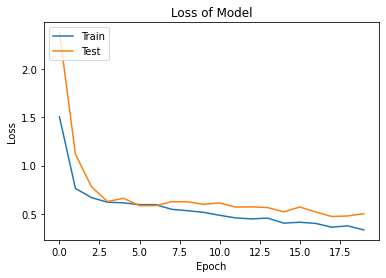

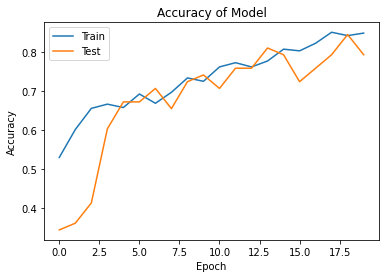

In [13]:
NN(Xtrain_imp,Ytrain_imp,Xtest_imp,Ytest_imp)